In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
from IPython.core.debugger import set_trace

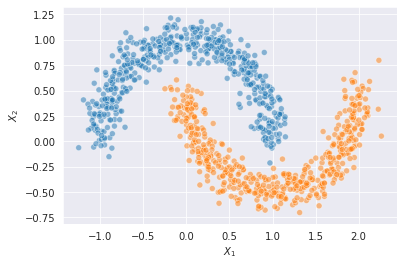

In [2]:
sns.set_style("darkgrid")

n_samples = 1000
n_noisy_dimensions = 1000

X, y = datasets.make_moons(n_samples=n_samples, noise=0.1)
X = (X).astype(np.float32)

# Scatter plot, dots colored by class value
df = pd.DataFrame(data = {"x": X[:,0], "y": X[:,1], "category": y})
sns.scatterplot(
    x="x",
    y="y",
    data=df,
    hue="category",
    legend=False,
    alpha=0.5
)

plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.savefig("two_moons.png")

In [3]:
from models import MLP
import torch
from torch import optim
from torch.nn import MSELoss
from torch.nn import CrossEntropyLoss

torch.manual_seed(42)

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from data import BasicDataset

batch_size=32

learning_rate = 5e-4
prior_learning_rate = 5e-4

patience = 50

noise_mean = 0
noise_var = 1.0
noise = np.random.normal(loc=noise_mean, scale=noise_var, size=(n_samples, n_noisy_dimensions))
X_with_noise = np.concatenate((X, noise), axis=1)
X_with_noise = X_with_noise.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X_with_noise, y, test_size=0.4
)

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5)

train_dataset = BasicDataset(X_train, y_train)
valid_dataset = BasicDataset(X_valid, y_valid)
test_dataset = BasicDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, batch_size=y_valid.shape[0])
test_loader = DataLoader(test_dataset, batch_size=y_test.shape[0])

In [5]:
D_in = X_with_noise.shape[1]
H1 = D_in // 2
H2 = H1 // 2
D_out = 2

f1 = MLP(D_in = D_in, H1 = H1, H2 = H2, D_out = D_out, dropout = 0.0).cuda()
f1_optimizer = optim.Adam(f1.parameters(), lr=learning_rate)

Running this next cell demonstrates that a basic MLP only learns noise in the data, and not any meaningful features.

In [6]:
from utils import EarlyStopping

criterion = CrossEntropyLoss()

mlp_accuracies = []
def train(model, batch_size):
    
    print("Beginning model training at {}".format(datetime.datetime.now()))
    
    early_stopping = EarlyStopping(patience=patience, minimize=False)
    epoch = 0
    
    while True:
        start_time = time.time()
        
        model.train()
        for X_batch, y_batch in train_loader:
            y_batch = y_batch.squeeze()
            X_batch = torch.FloatTensor(X_batch).cuda()
            y_batch = torch.LongTensor(y_batch).cuda()
            
            f1_optimizer.zero_grad()
            
            output = model(X_batch)
            loss_train = criterion(output, y_batch)
            loss_train.backward()
            f1_optimizer.step()
            
        model.eval()
        for X_batch, y_batch in valid_loader:
            y_batch = y_batch.squeeze()
            X_batch = torch.FloatTensor(X_batch).cuda()
            y_batch = torch.LongTensor(y_batch).cuda()
            
            output = model(X_batch)
            loss_valid = criterion(output, y_batch).item()
            class_probabilities = torch.nn.Softmax()(output)
            predicted_classes = torch.argmax(class_probabilities, dim=1)
            correct_predictions = (predicted_classes == y_batch).float()
            accuracy = (correct_predictions.sum()/correct_predictions.shape[0]).item()
            #set_trace()
            end_time = time.time()
            epoch_time = end_time - start_time
            mlp_accuracies.append(accuracy)
            
        if epoch % 10 == 0:
            print("Epoch {} completed in {} secs with validation loss, accuracy {:.4f},{:.4f}".format(epoch, epoch_time, loss_valid, accuracy))
           
        epoch += 1
        # early_stopping needs the validation loss to check if it has decreased, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(accuracy, model)
        
        if early_stopping.early_stop:
            print("Early stopping on epoch {}".format(epoch))
            break
            
    model.load_state_dict(torch.load('checkpoint.pt'))
    for X_batch, y_batch in test_loader:
        y_batch = y_batch.squeeze()
        X_batch = torch.FloatTensor(X_batch).cuda()
        y_batch = torch.LongTensor(y_batch).cuda()

        output = model(X_batch)
        loss_valid = criterion(output, y_batch).item()
        class_probabilities = torch.nn.Softmax()(output)
        predicted_classes = torch.argmax(class_probabilities, dim=1)
        correct_predictions = (predicted_classes == y_batch).float()
        accuracy = (correct_predictions.sum()/correct_predictions.shape[0]).item()
        #set_trace()
        end_time = time.time()
        epoch_time = end_time - start_time
    return accuracy

In [7]:
train(f1, batch_size)

Beginning model training at 2019-11-27 19:39:54.508036
Epoch 0 completed in 0.0733335018157959 secs with validation loss, accuracy 0.6706,0.5750


/homes/gws/ewein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EarlyStopping counter: 1 out of 50
EarlyStopping counter: 1 out of 50
EarlyStopping counter: 2 out of 50
EarlyStopping counter: 3 out of 50
EarlyStopping counter: 4 out of 50
Epoch 10 completed in 0.05772590637207031 secs with validation loss, accuracy 1.1034,0.6300
EarlyStopping counter: 5 out of 50
EarlyStopping counter: 6 out of 50
EarlyStopping counter: 7 out of 50
EarlyStopping counter: 8 out of 50
EarlyStopping counter: 9 out of 50
EarlyStopping counter: 10 out of 50
EarlyStopping counter: 11 out of 50
EarlyStopping counter: 12 out of 50
EarlyStopping counter: 13 out of 50
EarlyStopping counter: 14 out of 50
Epoch 20 completed in 0.0600581169128418 secs with validation loss, accuracy 1.1952,0.6300
EarlyStopping counter: 15 out of 50
EarlyStopping counter: 16 out of 50
EarlyStopping counter: 17 out of 50
EarlyStopping counter: 18 out of 50
EarlyStopping counter: 19 out of 50
EarlyStopping counter: 20 out of 50
EarlyStopping counter: 21 out of 50
EarlyStopping counter: 22 out of 50

/homes/gws/ewein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.5600000023841858

In [8]:
import egexplainer
import importlib

importlib.reload(egexplainer)

APExp = egexplainer.VariableBatchExplainer(train_dataset)

In [9]:
from models import LinearModel

D_in = X_with_noise.shape[1]
H1 = D_in // 2
H2 = H1 // 2
D_out = 2

f1 = MLP(D_in = D_in, H1 = H1, H2 = H2, D_out = D_out, dropout = 0.0).cuda()
f1_optimizer = optim.Adam(f1.parameters(), lr=learning_rate)

std = X_train.std(axis=0).reshape(-1,1)
mean = X_train.mean(axis=0).reshape(-1,1)

prior_info = np.concatenate((std, mean), axis=1)
prior_info = torch.FloatTensor(prior_info).cuda()

D_in = prior_info.shape[1]

f2 = LinearModel(D_in = D_in, D_out = 1).cuda()
f2_optimizer = optim.Adam(f2.parameters(), lr=prior_learning_rate)

In [10]:
prior_accuracies = []
def train_with_learned_prior(f1, f2, batch_size):
     
    classification_criterion = CrossEntropyLoss()
    
    print("Beginning model training at {}".format(datetime.datetime.now()))
    
    early_stopping = EarlyStopping(patience=patience, verbose=True, minimize=False)
    epoch = 0
    
    while True:
        start_time = time.time()
        f1.train()
        f2.train()
        
        for X_batch, y_batch in train_loader:
            y_batch = y_batch.squeeze()
            X_batch = torch.FloatTensor(X_batch).cuda()
            y_batch = torch.LongTensor(y_batch).cuda()
        
            f1_optimizer.zero_grad()
            f2_optimizer.zero_grad()
            
            output = f1(X_batch)
            classification_loss = classification_criterion(output, y_batch)
            
            eg = APExp.shap_values(f1, X_batch, sparse_labels=y_batch)
            prior_differences = f2(prior_info).squeeze()
            
            # This works pretty well! Why?
            prior_loss = (prior_differences - eg).abs().mean()
            train_loss = classification_loss + prior_loss
            
            train_loss.backward()
            f1_optimizer.step()
            f2_optimizer.step()
            
        
        f1.eval()
        for X_batch, y_batch in valid_loader:
            y_batch = y_batch.squeeze()
            X_batch = torch.FloatTensor(X_batch).cuda()
            y_batch = torch.LongTensor(y_batch).cuda()
            output = f1(X_batch)
            loss_valid = classification_criterion(output, y_batch)
            
            class_probabilities = torch.nn.Softmax()(output)
            predicted_classes = torch.argmax(class_probabilities, dim=1)
            correct_predictions = (predicted_classes == y_batch).float()
            accuracy = (correct_predictions.sum()/correct_predictions.shape[0]).item()
            end_time = time.time()
            epoch_time = end_time - start_time
            prior_accuracies.append(accuracy)
            
        if epoch % 10 == 0:
            print("Epoch {} completed in {} secs with test loss, accuracy {:.4f},{:.4f}".format(epoch, epoch_time, loss_valid, accuracy))
        
        # early_stopping needs the validation loss to check if it has decreased, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(accuracy, f1)
        epoch += 1
        if early_stopping.early_stop:
            print("Early stopping on epoch {}".format(epoch))
            break
            
    f1.load_state_dict(torch.load('checkpoint.pt'))
        
    for X_batch, y_batch in test_loader:
        y_batch = y_batch.squeeze()
        X_batch = torch.FloatTensor(X_batch).cuda()
        y_batch = torch.LongTensor(y_batch).cuda()

        output = f1(X_batch)
        loss_valid = criterion(output, y_batch).item()
        class_probabilities = torch.nn.Softmax()(output)
        predicted_classes = torch.argmax(class_probabilities, dim=1)
        correct_predictions = (predicted_classes == y_batch).float()
        accuracy = (correct_predictions.sum()/correct_predictions.shape[0]).item()
        #set_trace()
        end_time = time.time()
        epoch_time = end_time - start_time
    return accuracy

In [ ]:
train_with_learned_prior(f1, f2, 32)

Beginning model training at 2019-11-27 19:39:58.165668
Epoch 0 completed in 0.1669929027557373 secs with test loss, accuracy 0.6721,0.5850
Validation loss decreased (inf --> 0.585000).  Saving model ...


/homes/gws/ewein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation loss decreased (0.585000 --> 0.620000).  Saving model ...
EarlyStopping counter: 1 out of 50
Validation loss decreased (0.620000 --> 0.620000).  Saving model ...
EarlyStopping counter: 1 out of 50
Validation loss decreased (0.620000 --> 0.625000).  Saving model ...
EarlyStopping counter: 1 out of 50
Validation loss decreased (0.625000 --> 0.625000).  Saving model ...
Validation loss decreased (0.625000 --> 0.630000).  Saving model ...
Validation loss decreased (0.630000 --> 0.645000).  Saving model ...
Epoch 10 completed in 0.15909171104431152 secs with test loss, accuracy 0.6496,0.6400
EarlyStopping counter: 1 out of 50
Validation loss decreased (0.645000 --> 0.675000).  Saving model ...
Validation loss decreased (0.675000 --> 0.675000).  Saving model ...
Validation loss decreased (0.675000 --> 0.700000).  Saving model ...
Validation loss decreased (0.700000 --> 0.715000).  Saving model ...
Validation loss decreased (0.715000 --> 0.735000).  Saving model ...
Validation loss

In [ ]:
sns.set_style("darkgrid")
plt.plot(mlp_accuracies, label="MLP")
plt.plot(prior_accuracies, label="MLP w/ Learned Prior")
plt.xlabel("Epoch")
plt.ylabel("Validation Set Accuracy")
plt.legend()
plt.show()

In [ ]:
from sklearn import linear_model

clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train, y_train)

predictions = clf.predict(X_train)
predictions = [0 if prediction < 0.5 else 1 for prediction in predictions]
results = predictions == y_train
results.sum()/results.shape[0]

In [ ]:
import shap

real_feature_names = ["$X_1$", "$X_2$"]
noisy_feature_names = ["Noise Feature {}".format(str(i)) for i in range(n_noisy_dimensions)]
all_feature_names = real_feature_names + noisy_feature_names

for X_batch, y_batch in test_loader:
    y_batch = y_batch.squeeze()
    X_batch = torch.FloatTensor(X_batch).cuda()
    y_batch = torch.LongTensor(y_batch).cuda()
    eg = APExp.shap_values(f1, X_batch, sparse_labels=y_batch).cpu().detach().numpy()
    shap.summary_plot(
        eg,
        X_batch,
        plot_type="bar",
        feature_names=all_feature_names,
        max_display=10
    )
    

In [ ]:
from data import BasicDataset

prior_data = BasicDataset(X = prior_info, y = np.zeros(prior_info.shape[0]))

meta_APExp = egexplainer.VariableBatchExplainer(prior_data)

In [ ]:
for X_batch, y_batch in test_loader:
    y_batch = y_batch.squeeze()
    X_batch = torch.FloatTensor(X_batch).cuda()
    y_batch = torch.LongTensor(y_batch).cuda()
    predicted_attributions = f2(prior_info).squeeze().abs().cpu().detach().numpy()
    meta_eg = meta_APExp.shap_values(f2, prior_info).abs().cpu().detach().numpy()

In [ ]:
meta_eg = meta_eg/meta_eg.sum(axis=1, keepdims=True)
meta_eg = (meta_eg.T * predicted_attributions).T
df = pd.DataFrame(data={
    "stdev": meta_eg[:,0],
    "mean": meta_eg[:,1],
    "total_attribution": meta_eg.sum(axis=1),
    "y":all_feature_names
})

In [ ]:
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
main_plot = sns.barplot(
    x = "stdev",
    y = "y",
    data=df.nlargest(10, "total_attribution"),
    color = "red")

bottom_plot = sns.barplot(x = "mean", y = "y", data=df.nlargest(10, "total_attribution"), color = "#0000A3")

topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
l = plt.legend(
    [bottombar, topbar],
    ['Feature Mean', 'Feature Stdev'],
    ncol = 2,
    prop={'size':24}
)
l.draw_frame(False)

sns.despine(left=True)
bottom_plot.set_ylabel("Feature")
bottom_plot.set_xlabel("Predicted Feature Importance")

main_plot.set_title(
    "Feature Importance Explanations", fontsize=24
)


#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(24)
    
plt.tight_layout()